This notebook serves as a starting point for the final project of the Introduction to Machine Learning 2024/25 course. You must use exactly the code provided to load and split the dataset.

# Code to load the dataset

In [1]:
!pip install -U "datasets==3.6.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [2]:
### YOU MUST NOT CHANGE THIS CELL! ###

from datasets import load_dataset

full_dataset = load_dataset("skeskinen/TinyStories-GPT4", split="train")
full_dataset = full_dataset.remove_columns([c for c in full_dataset.column_names if c not in ["story", "features"]])
assert len(full_dataset) == 2745100

splits = full_dataset.train_test_split(test_size=10000, seed=42, shuffle=True)

train_dataset = splits["train"]
test_dataset  = splits["test"]

assert len(train_dataset) == 2735100
assert len(test_dataset)  == 10000

assert train_dataset[0]["story"][:33] == "One day, a little girl named Lily"
assert train_dataset[0]["features"] == ["Dialogue", "Conflict"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/554 [00:00<?, ?B/s]

(…)-00000-of-00008-c63ccd5d5290f4a1.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00001-of-00008-478199d8ac044910.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00002-of-00008-9b868f59be94d815.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00003-of-00008-d183cca02834cd90.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00004-of-00008-5f8ac0bb66de5834.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00005-of-00008-e8c22c3e776b87dd.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00006-of-00008-941f57106aca3340.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00007-of-00008-771d8aa2d5ce5c95.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2745100 [00:00<?, ? examples/s]

In [3]:
# Here we print the first example of the train dataset

from pprint import pprint
pprint(train_dataset[0])

{'features': ['Dialogue', 'Conflict'],
 'story': 'One day, a little girl named Lily went for a walk with her mom. '
          'They saw a big cliff near the water. Lily was fearful and did not '
          "want to go near the cliff. She held her mom's hand tight.\n"
          '"Mom, I am scared," Lily said. Her mom looked at her and smiled. '
          '"It\'s okay to be scared, but I will tell you a secret. When I am '
          'scared, I take a deep breath and count to three. Then, I feel '
          'better."\n'
          'Lily tried what her mom said. She took a deep breath and counted to '
          'three. She felt better and was not as scared. Then, a big bird flew '
          'by and almost hit Lily. She was scared again, but her mom was there '
          'to help her.\n'
          '"Remember what I told you, Lily. Take a deep breath and count to '
          'three," her mom said. Lily did it again, and she felt better. They '
          'walked away from the cliff, and Lily wa

# MODEL 1 : pretrained model RoBERTa

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

from torch.nn import BCEWithLogitsLoss
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, confusion_matrix
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader, TensorDataset
from collections import defaultdict

In [5]:
# Fix the seed for the reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
TAGS = ["BadEnding", "Conflict", "Dialogue", "Foreshadowing", "MoralValue", "Twist"]

def f1_per_tag(true_tag_lists, pred_tag_lists):

    scores = f1_score(true_tag_lists, pred_tag_lists, average=None, zero_division=0)
    return {t: float(s) for t, s in zip(TAGS, scores)}

In [8]:
num_labels = len(TAGS)

Create a smaller training dataset that is representative of all the labels:

Since we are unable to train the model on the entire dataset of stories, we want to create a smaller training set that is representative of all the labels. We impose a minimum number of stories for each label to ensure that no tag is significantly underrepresented.

In [ ]:
# Construction of a small training dataset
target_size = 50000      # Dimension of the small dataset
min_per_tag = 1000       # Minimum number of stories per tag


#Map each label to the list of indices of the stories that contain it

tag_to_indices = defaultdict(list) #Create a dictionary that maps each tag to an empty list.
for idx, example in enumerate(train_dataset): #Iterate over each example in the train_dataset, retrieving the index idx of the current example.
    for tag in example['features']:
        if tag in TAGS:
            tag_to_indices[tag].append(idx) #If the tag is one of the tags of interest, it adds the index idx of that story to the list corresponding to that tag in the dictionary.

# To avoid duplicated stories
final_indices = set()
for tag in TAGS:
    indices_for_tag = tag_to_indices[tag] #Retrieves the list of story indices containing that tag from the previously created tag_to_indices dictionary.

    num_to_sample = min(min_per_tag, len(indices_for_tag))  # If there are less stories with that tag than min_per_tag we take them all
    sampled_indices = random.sample(indices_for_tag, num_to_sample) #Randomly samples num_to_sample indices from the indices_for_tag list.
    final_indices.update(sampled_indices) #Adds the sampled indices to the final_indices set.

print(f"Unique stories after guaranteeing minimums: {len(final_indices)}")

# Add random stories to reach target_size.
num_to_add = target_size - len(final_indices) #how many stories left to reach target_size
if num_to_add > 0:
    # Identify all the indices not already selected
    all_indices = set(range(len(train_dataset)))
    remaining_indices = list(all_indices - final_indices)

    random.shuffle(remaining_indices) # Shuffle the remaining indices

    final_indices.update(remaining_indices[:num_to_add]) # Add the first num_to_add indices of the shuffled list

# Create the final dataset from the selected indices
final_indices_list = list(final_indices) #Convert it to a list otherwise it cannot be shuffled
random.shuffle(final_indices_list) #to avoid having an ordered dataset

#To ensure the final dimension to be target_size
if len(final_indices_list) > target_size:
    final_indices_list = final_indices_list[:target_size]

#Reduced 'controlled' dataset
small_dataset = train_dataset.select(final_indices_list)

print(f"Final 'small_dataset' created with {len(small_dataset)} stories.")

# Verify the new label distribution
print("\nVerifying the new label distribution:")
new_counts = {tag: 0 for tag in TAGS}
for item_features in small_dataset['features']:
    for feature in item_features:
        if feature in new_counts:
            new_counts[feature] += 1
pprint(new_counts)

# Extract stories and labels from the small dataset
stories, labels = small_dataset['story'], small_dataset['features']

Unique stories after guaranteeing minimums: 5994
Final 'small_dataset' created with 50000 stories.

Verifying the new label distribution:
{'BadEnding': 5413,
 'Conflict': 5473,
 'Dialogue': 27273,
 'Foreshadowing': 5401,
 'MoralValue': 5880,
 'Twist': 10386}


Convert every label to a binary vector:

We define a mapping from each label to a unique index, then create a function to convert lists of labels into binary vectors. This allows us to represent the presence or absence of each label as 1s and 0s for model training.

In [ ]:
label_to_index = {label: i for i, label in enumerate(TAGS)} # Map each label to a unique index (BadEnding->0, Conflict->1,...)

In [ ]:
def list_to_binary(label_list):
    vector = [0] * len(TAGS) # Initialize a binary vector of zeros with length equal to number of labels
    for label in label_list:
        label = label.strip() # Remove any extra whitespace around the label
        vector[label_to_index[label]] = 1 # Set the position corresponding to this label to 1
    return vector

def binary_to_list(vector):
  return [TAGS[i] for i, value in enumerate(vector) if value == 1]

# convert all labels into binary vectors
labels_bin = [list_to_binary(label) for label in labels]

Split the 'controlled' smaller dataset into training and validation sets, keeping 80% for training and 20% for validation, with a fixed random seed for reproducibility.


In [ ]:
train_stories, val_stories, train_labels, val_labels = train_test_split(stories, labels_bin, test_size=0.2, random_state=42)

Load a pre-trained tokenizer and prepare the model architecture for further fine-tuning or inference.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Create the DataLoader

In [ ]:
# Tokenization
train_encodings = tokenizer(train_stories, truncation=True, padding='max_length', max_length=256, return_tensors="pt")
val_encodings = tokenizer(val_stories, truncation=True, padding='max_length', max_length=256, return_tensors="pt")

train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float)

# Dataset
train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels_tensor)
val_dataset = TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], val_labels_tensor)

# DataLoader for batching
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)


Define the training and evaluating procedure

In [ ]:
def training_procedure(model, optimizer, loader, epochs, loss_fn, validation_loader):
    model.to(device)

    scheduler = StepLR(optimizer, step_size=round(epochs * 3/4), gamma=0.1, verbose=True)

    best_f1_scores_per_tag = np.zeros(len(TAGS))

    for epoch in range(epochs):
        model.train() #set model in training model
        losses = []

        for batch in loader:
            input_ids = batch[0].to(device) #move input data to the device
            attention_mask = batch[1].to(device)
            labels = batch[2].float().to(device)

            optimizer.zero_grad()
            output = model(input_ids=input_ids, attention_mask=attention_mask) #forward step
            loss = loss_fn(output.logits, labels) #compute the loss
            loss.backward() #backpropagation
            optimizer.step() #update the weights

            losses.append(loss.item())

        print(f'Train epoch: {epoch + 1} | Loss: {np.mean(losses):.4f}')

        # Validation
        current_avg_loss, current_f1_values, _, _, _ = evaluate_model(model, validation_loader, loss_fn)

        # Check for improved model (at least one F1 better, and the rest not below 0.75)
        improvements = current_f1_values > best_f1_scores_per_tag
        at_least_one_improved = improvements.any()

        # Acceptable degradation (they must remain > 0.75)
        non_improved = ~improvements
        acceptable_degradation = np.all(current_f1_values[non_improved] >= 0.75) # boolean variable: True if all the tags have improved and they are > 0.75

        if at_least_one_improved and acceptable_degradation:
          best_f1_scores_per_tag = current_f1_values.copy()
          torch.save(model.state_dict(), "best_model_RoBERTa.pt")
          print(f"✅ New best model saved (F1-based)")

        scheduler.step() #update learning rate
        print(f"Learning rate: {scheduler.get_last_lr()}")

    return

In [ ]:
def evaluate_model(model, loader, loss_fn, thresholds=None):
    model.to(device)
    model.eval()

    if thresholds is None:
      thresholds = [0.5] * len(TAGS)

    # Initialization
    loss = 0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].float().to(device)

            output = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = output.logits
            loss += loss_fn(logits, labels).item()  #update the loss

            all_targets.append(labels.cpu().numpy())
            all_outputs.append(logits.cpu().numpy())



    # Avarage loss
    loss /= len(loader)

    # Calculate F1 score per tag
    all_targets = np.concatenate(all_targets, axis=0)
    all_outputs = np.concatenate(all_outputs, axis=0)

    # Apply sigmoid and threshold to get binary predictions
    pred_probabilities = torch.sigmoid(torch.tensor(all_outputs)).numpy()
    pred_tags = (pred_probabilities > thresholds).astype(int)

    # Calculates F1 scores per label
    f1_scores = f1_per_tag(all_targets, pred_tags)
    current_f1_values = np.array([f1_scores[tag] for tag in TAGS]) #array with f1 values

    print(f"Evaluation loss: {loss:.4f}")
    print("F1 Score per tag:")
    for tag, score in f1_scores.items():
        print(f"  {tag}: {score:.4f}")

    return loss, current_f1_values, pred_probabilities, pred_tags, all_targets

Define the model and train it

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=6,
    problem_type="multi_label_classification" #configures the model for multi-label classification tasks
)

model.to(device)
print(model)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

#Training loop

In [ ]:
# Hyperparameters

learning_rate = 2e-5
epochs = 4
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = BCEWithLogitsLoss()        #suitable for multi-label classification. Expects raw logits as input (applies sigmoid internally).

#Training loop
training_procedure(model, optimizer, train_dataloader, epochs, loss_fn, validation_loader=val_dataloader)

Train epoch: 1 | Loss: 0.2048
Evaluation loss: 0.1714
F1 Score per tag:
  BadEnding: 0.9331
  Conflict: 0.4061
  Dialogue: 0.9081
  Foreshadowing: 0.4183
  MoralValue: 0.8429
  Twist: 0.8882
✅ New best model saved (F1-based)
Learning rate: [2e-05]
Train epoch: 2 | Loss: 0.1447
Evaluation loss: 0.1491
F1 Score per tag:
  BadEnding: 0.9352
  Conflict: 0.5274
  Dialogue: 0.9264
  Foreshadowing: 0.4303
  MoralValue: 0.8423
  Twist: 0.9037
✅ New best model saved (F1-based)
Learning rate: [2e-05]
Train epoch: 3 | Loss: 0.1249
Evaluation loss: 0.1462
F1 Score per tag:
  BadEnding: 0.9321
  Conflict: 0.5494
  Dialogue: 0.9283
  Foreshadowing: 0.4092
  MoralValue: 0.8533
  Twist: 0.9004
Learning rate: [2.0000000000000003e-06]
Train epoch: 4 | Loss: 0.0912
Evaluation loss: 0.1434
F1 Score per tag:
  BadEnding: 0.9400
  Conflict: 0.5899
  Dialogue: 0.9321
  Foreshadowing: 0.5403
  MoralValue: 0.8642
  Twist: 0.9112
✅ New best model saved (F1-based)
Learning rate: [2.0000000000000003e-06]


We evaluate the model in order to be able to compute the precision-recall curve that allows us to find the best thresholds.

In [ ]:
_, _, val_predicted_probs, val_predicted_tags, val_true_tags = evaluate_model(model, val_dataloader, loss_fn)

Evaluation loss: 0.1433
F1 Score per tag:
  BadEnding: 0.9400
  Conflict: 0.5899
  Dialogue: 0.9321
  Foreshadowing: 0.5403
  MoralValue: 0.8642
  Twist: 0.9112


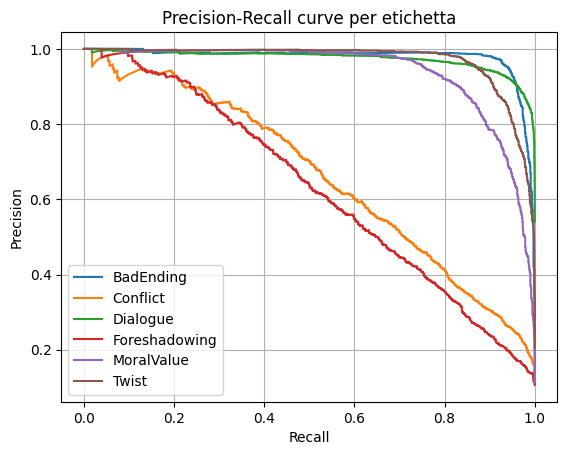

In [ ]:
for i in range(val_true_tags.shape[1]):
    precision, recall, _ = precision_recall_curve(val_true_tags[:, i], val_predicted_probs[:, i])
    plt.plot(recall, precision, label=TAGS[i])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve per label")
plt.legend()
plt.grid(True)
plt.savefig("precision_recall_curve.png")
plt.show()

The curve shows how precision and recall change as we vary the
threshold, and the best threshold is typically the one that maximizes the F1-score.

In [ ]:
best_thresholds = []

for i in range(len(TAGS)):
    precision, recall, thresholds = precision_recall_curve(val_true_tags[:, i], val_predicted_probs[:, i])

    # F1-score for every point
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

    # Find the index that maximizes the F1-score
    best_index = np.argmax(f1_scores)

    best_threshold = thresholds[best_index]
    best_thresholds.append(best_threshold)

    print(f"Tag {TAGS[i]} - Best threshold: {best_threshold:.2f}, F1: {f1_scores[best_index]:.4f}")


Tag BadEnding - Best threshold: 0.84, F1: 0.9476
Tag Conflict - Best threshold: 0.39, F1: 0.6058
Tag Dialogue - Best threshold: 0.46, F1: 0.9326
Tag Foreshadowing - Best threshold: 0.20, F1: 0.5779
Tag MoralValue - Best threshold: 0.47, F1: 0.8660
Tag Twist - Best threshold: 0.42, F1: 0.9116
